## Praca domowa nr 4, Bartosz Jamroz

In [1]:
import dalex as dx

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Apartments

In [20]:
df_apart=dx.datasets.load_apartments()
df_apart.shape

(1000, 6)

Za dokumentacją :

Datasets 'apartments' and 'apartments_test' are artificial, generated from the same model. Structure of the dataset is copied from the real dataset from the PBImisc R package, but they were generated in a way to mimic the effect of Anscombe quartet for complex black-box models.



In [21]:
df_apart_test=dx.datasets.load_apartments_test()
df_apart_test.shape

(9000, 6)

Opis z PBImisc:
Dataset contains offer and transictional prices for apartments sold in in Warsaw in years 2007-2009

m2.price - price per m2

construction.date - the construction year

surface - apartment area in m2

n.rooms - number of rooms

In [35]:
df_apart_all= pd.concat([df_apart,df_apart_test])

In [37]:
df_apart_all.head()

,m2_price,construction_year,surface,floor,no_rooms,district
1,5897,1953,25,3,1,Srodmiescie
2,1818,1992,143,9,5,Bielany
3,3643,1937,56,1,2,Praga
4,3517,1995,93,7,3,Ochota
5,3013,1992,144,6,5,Mokotow


In [38]:
df_apart_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   m2_price           10000 non-null  int64 
 1   construction_year  10000 non-null  int64 
 2   surface            10000 non-null  int64 
 3   floor              10000 non-null  int64 
 4   no_rooms           10000 non-null  int64 
 5   district           10000 non-null  object
dtypes: int64(5), object(1)
memory usage: 546.9+ KB


Ramki nie wymagają imputacji braków 

In [40]:
df_apart_all.district.value_counts()

Praga          1063
Ursus          1025
Srodmiescie    1024
Ochota         1005
Wola            998
Bemowo          994
Bielany         990
Mokotow         975
Ursynow         967
Zoliborz        959
Name: district, dtype: int64

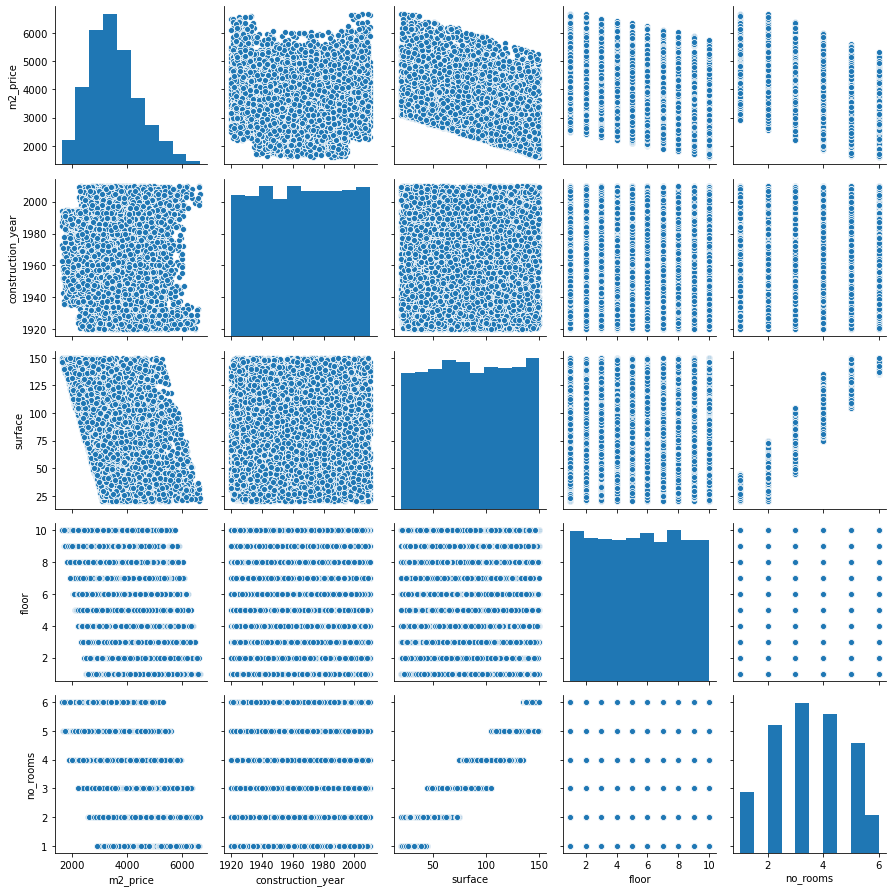

In [41]:
sns.pairplot(df_apart_all)
plt.tight_layout()

 Effect of Anscombe quartet:
 
 Dane  nie mają realnego sensu są sztucznie powybierane z oryginalnego zbioru by symulować „Effect of Anscombe quartet”
 
 Zmienna celu:
 

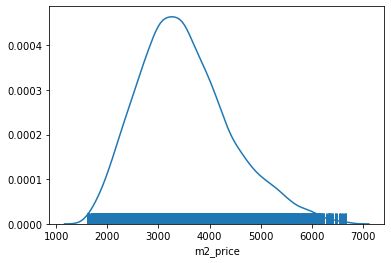

In [42]:
p=sns.distplot(df_apart_all['m2_price'],rug=True, hist=False);

## Modele apartments

In [56]:
X1_train=df_apart.drop(["m2_price"],axis=1)
y1_train=df_apart['m2_price']

X1_test=df_apart_test.drop(["m2_price"],axis=1)
y1_test=df_apart_test['m2_price']


In [76]:
# nieskalowany
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from category_encoders import TargetEncoder
from sklearn.metrics import mean_squared_error


pipe1=Pipeline([ 
    ('encoder',TargetEncoder(cols=['district']) ),
    ('model',SVC())])

pipe1.fit(X1_train,y1_train)

y_train_hat=pipe.predict(X1_train)
print(mean_squared_error(y1_train,y_train_hat,squared=False))

y_test_hat=pipe1.predict(X1_test)
print(mean_squared_error(y1_test,y_test_hat,squared=False))


519.5899719971509
902.6116555123065


In [75]:
# skalowany
from sklearn.preprocessing import StandardScaler

pipe2=Pipeline([ 
    ('encoder',TargetEncoder(cols=['district']) ),
    ('scaler', StandardScaler()),
    ('model',SVC())])

pipe2.fit(X1_train,y1_train)

y_train_hat=pipe2.predict(X1_train)
print(mean_squared_error(y1_train,y_train_hat,squared=False))

y_test_hat=pipe2.predict(X1_test)
print(mean_squared_error(y1_test,y_test_hat,squared=False))

858.1576717250676
855.5316837506717


Przy braku skalowania model lepiej dopasował się do danych treningowych jednak sporo wypada sporo gorzej na zbiorze testowym.

W przypadku skalowania danych model ma podobne wyniki na zbiorze treningowym i testowym 


In [91]:
# strojenie 
from sklearn.model_selection import RandomizedSearchCV
param_grid ={ 'model__C':np.linspace(0.0, 5.0, num=100),
        'model__gamma':['scale', 'auto'],
        'model__degree':np.arange(0,10)}
random=RandomizedSearchCV(estimator=pipe2, param_distributions=param_grid, cv = 10, n_jobs=-1, random_state=123)
random.fit(X1_train,y1_train)
print((random.best_params_))

y_train_hat=random.predict(X1_train)
print(mean_squared_error(y1_train,y_train_hat,squared=False))

y_test_hat=random.predict(X1_test)
print(mean_squared_error(y1_test,y_test_hat,squared=False))

{'model__gamma': 'scale', 'model__degree': 3, 'model__C': 4.444444444444445}
698.0068171951494
695.5021440377396


Po wytrenowaniu modelu pracującego na skalowanych danych jego wyniki się poprawiły, model dalej działa stabilnie na zbiorze testowym i treningowym 

## California housing prices
dane pochodzą z https://www.kaggle.com/camnugent/california-housing-prices

Przedstawiają kalifornijskie nieruchomości, kolumną celu jest wartość nieruchomości 

Opis:

### Opis
1. longitude: A measure of how far west a house is; a higher value is farther west

2. latitude: A measure of how far north a house is; a higher value is farther north

3. housingMedianAge: Median age of a house within a block; a lower number is a newer building

4. totalRooms: Total number of rooms within a block

5. totalBedrooms: Total number of bedrooms within a block

6. population: Total number of people residing within a block

7. households: Total number of households, a group of people residing within a home unit, for a block

8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. medianHouseValue: Median house value for households within a block (measured in US Dollars)

10. oceanProximity: Location of the house w.r.t ocean/sea

In [2]:
df_house = pd.read_csv('housing.csv')

In [93]:
df_house.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


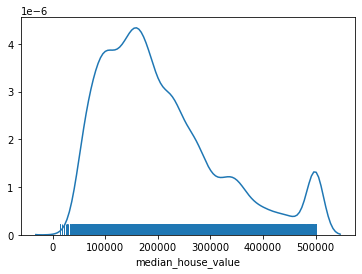

In [95]:
p=sns.distplot(df_house['median_house_value'],rug=True, hist=False);

In [97]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


W przypadku tych danych zmienna celu nie ma już tak  „ładnego” rozkładu, w wartościach domów mamy dwa piki, jednak drugi szczyt jest spowodowany obcięciem maksymalnej ceny do 500 tyś. 

Zbiór posiada braki w liczbie sypialni

In [10]:
df_house=df_house.dropna()

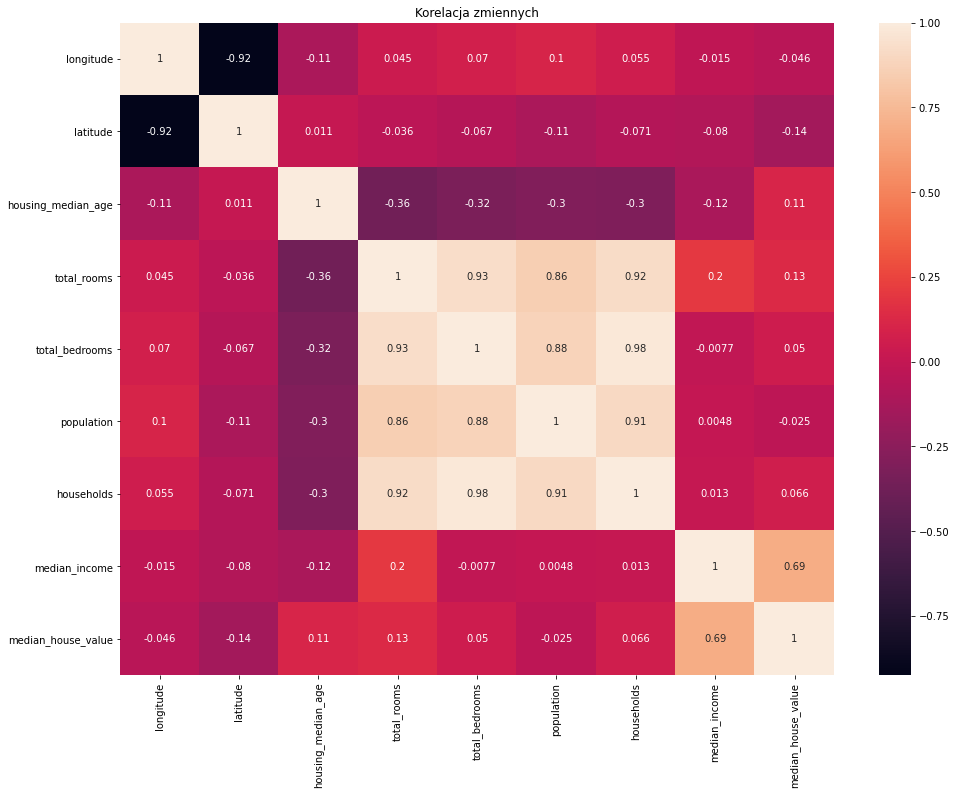

In [98]:
#macierz korelacji
corr = df_house.corr()
f, ax = plt.subplots(figsize=(16, 12))
ax.set_title('Korelacja zmiennych')
sns.heatmap(corr, xticklabels=corr.columns,
            yticklabels=corr.columns, annot=True);

Długość i szerokość geograficzna są ze sobą skorelowane(Kalifornia leży raczej skośnie na mapie)


Ze zamienna targowa najbardziej skorelowana jest dochód mieszkańców, całkiem logiczne im ktoś zamożniejszy tym droższy dom może  kupić


## Modele California housing prices

In [4]:
df_house.sample(frac = 0.1) # ograniczenie ze względów wydajnościowych (bardzo duże ograniczenie, a na potrzebę zadania założę ze wszystko jest ok )

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
6106,-117.89,34.11,27.0,2434.0,535.0,1623.0,498.0,3.6875,140200.0,<1H OCEAN
7967,-118.19,33.86,36.0,2013.0,546.0,1659.0,522.0,3.1215,153600.0,<1H OCEAN
17634,-121.93,37.27,28.0,3428.0,753.0,1753.0,729.0,4.1033,281000.0,<1H OCEAN
1962,-120.71,38.73,17.0,2146.0,396.0,862.0,351.0,2.9219,141300.0,INLAND
3859,-118.44,34.17,29.0,2685.0,642.0,1085.0,599.0,3.2763,279400.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
3460,-118.45,34.31,9.0,1739.0,358.0,820.0,323.0,4.0556,182500.0,<1H OCEAN
9350,-122.57,37.97,47.0,5416.0,1115.0,2177.0,1027.0,3.5055,382100.0,NEAR BAY
5406,-118.44,34.03,30.0,1039.0,303.0,606.0,274.0,3.1250,343800.0,<1H OCEAN
9799,-121.92,36.54,33.0,5323.0,887.0,1670.0,740.0,3.9792,468000.0,NEAR OCEAN


In [11]:
from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(df_house.drop(['median_house_value'],axis=1),
                                                        df_house['median_house_value'], test_size=0.3, random_state=42)

In [12]:
# nieskalowany
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from category_encoders import TargetEncoder
from sklearn.metrics import mean_squared_error
from category_encoders import OneHotEncoder

pipe1=Pipeline([ 
    ('encoder',OneHotEncoder(cols=['ocean_proximity']) ),
    ('model',SVR())])

pipe1.fit(X2_train,y2_train)

y_train_hat=pipe1.predict(X2_train)
print(mean_squared_error(y2_train,y_train_hat,squared=False))

y_test_hat=pipe1.predict(X2_test)
print(mean_squared_error(y2_test,y_test_hat,squared=False))


118332.72100127704
118070.49884691309


In [13]:
# skalowany
from sklearn.preprocessing import StandardScaler

pipe2=Pipeline([ 
    ('encoder',OneHotEncoder(cols=['ocean_proximity']) ),
    ('scaler', StandardScaler()),
    ('model',SVR())])

pipe2.fit(X2_train,y2_train)

y_train_hat=pipe2.predict(X2_train)
print(mean_squared_error(y2_train,y_train_hat,squared=False))

y_test_hat=pipe2.predict(X2_test)
print(mean_squared_error(y2_test,y_test_hat,squared=False))

118010.30402705516
117742.98836509143


W tym przypadku skalowanie wpłynęło minimalnie na wynik, delikatnie go oprawiając 

In [14]:
# strojenie 
from sklearn.model_selection import RandomizedSearchCV

param_grid ={ 'model__C':np.linspace(0.0, 5.0, num=100),
        'model__gamma':['scale', 'auto'],
        'model__degree':np.arange(0,10)}
random=RandomizedSearchCV(estimator=pipe2, param_distributions=param_grid, cv = 5, n_jobs=-1, random_state=123)

random.fit(X2_train,y2_train)
print((random.best_params_))

y_train_hat=random.predict(X2_train)
print(mean_squared_error(y2_train,y_train_hat,squared=False))

y_test_hat=random.predict(X2_test)
print(mean_squared_error(y2_test,y_test_hat,squared=False))

{'model__gamma': 'scale', 'model__degree': 3, 'model__C': 4.444444444444445}
116734.69655584404
116455.79636299884


Strojenie modelu także nie pomaga. Najwyraźniej svm średnio nadaje się dla tego problemu